In [72]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import mutual_info_score
from sklearn.metrics import mean_squared_error
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import ParameterGrid
import xgboost as xgb
import graphviz
sns.set_theme()

In [3]:
def df_info2(df):
    df_info = pd.DataFrame()
    df_info['dtype'] = df.dtypes
    df_info['#'] = df.count()
    df_info['#na'] = df.isna().sum()
    df_info['#unique'] = df.nunique()
    df_info['min'] = df.min()
    df_info['max'] = df.max()
    return df_info

## Loading the data

- Use only the following columns:
  - `'neighbourhood_group',`
  - `'room_type',`
  - `'latitude',`
  - `'longitude',`
  - `'minimum_nights',`
  - `'number_of_reviews','reviews_per_month',`
  - `'calculated_host_listings_count',`
  - `'availability_365',`
  - `'price'`
- Fill NAs with 0
- Apply the log tranform to `price`
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the `train_test_split` function and set the `random_state` parameter to 1
- Use `DictVectorizer` to turn the dataframe into matrices

In [5]:
s3_file_path = 's3://datasets/kaggle/dgomonov/new-york-city-airbnb-open-data/data.parquet'
df = pd.read_parquet(s3_file_path, storage_options={
    'profile': 'local',
    'client_kwargs': {
        'endpoint_url': 'http://192.168.46.220:9000'
    }
}, columns=[
    'neighbourhood_group',
    'room_type',
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count',
    'availability_365',
    'price'
])
# column names
df.columns = df.columns.str.lower().str.replace(' ', '_')

# column values
for c in df.columns[df.dtypes == 'object']:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [6]:
df_info2(df)

,dtype,#,#na,#unique,min,max
neighbourhood_group,object,48895,0,5,bronx,staten_island
room_type,object,48895,0,3,entire_home/apt,shared_room
latitude,float64,48895,0,19048,40.49979,40.91306
longitude,float64,48895,0,14718,-74.24442,-73.71299
minimum_nights,int64,48895,0,109,1,1250
number_of_reviews,int64,48895,0,394,0,629
reviews_per_month,float64,38843,10052,937,0.01,58.5
calculated_host_listings_count,int64,48895,0,47,1,327
availability_365,int64,48895,0,366,0,365
price,int64,48895,0,674,0,10000


In [7]:
df = df.fillna(0)

In [8]:
df_train, df_test = train_test_split(df, test_size=0.4, random_state=1, shuffle=True)
df_val, df_test = train_test_split(df_test, test_size=0.5)

In [9]:
y_train = np.log1p(df_train['price']).values
y_val = np.log1p(df_val['price']).values
y_test = np.log1p(df_test['price']).values
del df_train['price']
del df_val['price']
del df_test['price']

In [74]:
def train(df, y, model, **kwargs):
    dv = DictVectorizer(sparse=False)
    model.fit(dv.fit_transform(df.to_dict(orient='records')), y, **kwargs)
    return dv, model

In [28]:
def predict(dv, model, df):
    y_hat = model.predict(dv.transform(df.to_dict(orient='records')))
    return y_hat

In [75]:
def evaluate_grid(df_train, y_train, df_val, y_val, model, grid, train_kwargs):
    records = []
    for param in ParameterGrid(grid):
        dv, model = train(
            df_train, y_train,
            model.set_params(**param),
            **train_kwargs
        )
        y_hat = predict(dv, model, df_val)
        record = dict(param)
        record['rmse'] = mean_squared_error(y_val, y_hat, squared=False)
        records.append(record)
    return pd.DataFrame.from_dict(records)

## Question 1

Let's train a decision tree regressor to predict the price variable.

- Train a model with `max_depth=1`

Which feature is used for splitting the data?

- `room_type`
- `neighbourhood_group`
- `number_of_reviews`
- `reviews_per_month`

In [26]:
dv, model = train(df_train, y_train, DecisionTreeRegressor(max_depth=1))

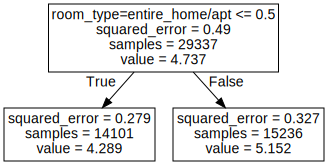

In [27]:
graphviz.Source(export_graphviz(model, feature_names=dv.get_feature_names_out()))

Ans: room_type

## Question 2

Train a random forest model with these parameters:

- `n_estimators=10`
- `random_state=1`
- `n_jobs=-1` (optional - to make training faster)

What's the RMSE of this model on validation?

- 0.059
- 0.259
- 0.459
- 0.659

In [41]:
default_params = dict(
    n_estimators=10,
    random_state=1,
    n_jobs=-1
)
dv, model = train(df_train, y_train, RandomForestRegressor(**default_params))

In [42]:
y_hat = predict(dv, model, df_val)
mean_squared_error(y_val, y_hat, squared=False)

0.46975351287485634

Ans: 0.469, close to 0.459

## Question 3

Now let's experiment with the `n_estimators` parameter

- Try different values of this parameter from 10 to 200 with step 10
- Set `random_state` to `1`
- Evaluate the model on the validation dataset

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

In [50]:
grid = dict(
    n_estimators=range(10, 201, 10)
)

df_scores = evaluate_grid(
    df_train, y_train, df_val, y_val,
    RandomForestRegressor(**default_params),
    grid
)

<AxesSubplot:xlabel='n_estimators', ylabel='rmse'>

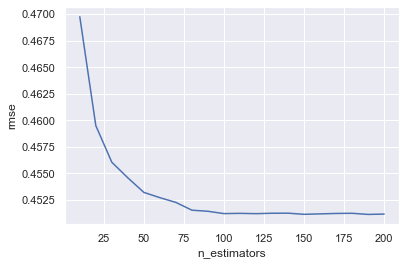

In [51]:
sns.lineplot(data=df_scores, x='n_estimators', y='rmse')

Ans: 120

## Question 4

Let's select the best `max_depth`:

- Try different values of `max_depth`: `[10, 15, 20, 25]`
- For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
- Fix the random seed: `random_state=1`

What's the best `max_depth`:

- 10
- 15
- 20
- 25

In [52]:
grid = dict(
    n_estimators=range(10, 201, 10),
    max_depth=[10, 15, 20, 25]
)

df_scores = evaluate_grid(
    df_train, y_train, df_val, y_val,
    RandomForestRegressor(**default_params),
    grid
)

In [57]:
df_scores.sort_values(by='rmse').head()

,max_depth,n_estimators,rmse
32,15,130,0.448392
34,15,150,0.448431
39,15,200,0.448436
31,15,120,0.448461
33,15,140,0.448464


Ans: 15

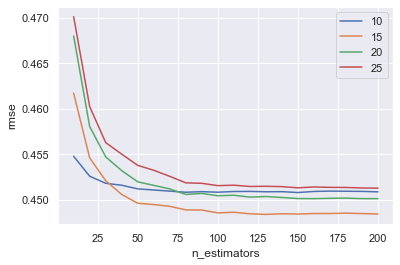

In [56]:
for gname, df_group in df_scores.groupby(by='max_depth'):
    sns.lineplot(data=df_group, x='n_estimators', y='rmse', label=gname)

**Bonus question (not graded):**

Will the answer be different if we change the seed for the model?


Ans: yes, maybe

## Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split.
When doint it, we can calculate "gain" - the reduction in impurity before and after the split.
This gain is quite useful in understanding what are the imporatant features
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field.

For this homework question, we'll find the most important feature:

- Train the model with these parametes:
  - `n_estimators=10`,
  - `max_depth=20`,
  - `random_state=1`,
  - `n_jobs=-1` (optional)
- Get the feature importance information from this model

What's the most important feature?

- `neighbourhood_group=Manhattan`
- `room_type=Entire home/apt`
- `longitude`
- `latitude`

In [58]:
dv, model = train()

In [59]:
default_params = dict(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)
dv, model = train(df_train, y_train, RandomForestRegressor(**default_params))

In [69]:
feature_w = dict(zip(dv.get_feature_names_out(), model.feature_importances_))
df_feature_w = pd.DataFrame.from_dict(feature_w, orient='index', columns=['weight'])

In [70]:
df_feature_w.sort_values(by='weight', ascending=False)

,weight
room_type=entire_home/apt,0.391285
longitude,0.158823
latitude,0.146983
availability_365,0.080650
reviews_per_month,0.055654
minimum_nights,0.050588
number_of_reviews,0.043872
calculated_host_listings_count,0.032574
neighbourhood_group=manhattan,0.028138
room_type=private_room,0.005595


Ans: `room_type=Entire home/apt`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` first to `0.1` and then to `0.01`

Which eta leads to the best RMSE score on the validation dataset?

- 0.3
- 0.1
- 0.01


In [84]:
xgb_default_params = dict(
    n_estimators=100,
    learning_rate=0.3,
    max_depth=6,
    min_child_weight=1,
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=1,
    verbosity=1
)

dv = DictVectorizer()
X_train = dv.fit_transform(df_train.to_dict(orient='records'))
X_val = dv.transform(df_val.to_dict(orient='records'))

In [96]:

df_score = pd.DataFrame()
for eta in [0.3, 0.1, 0.01]:
    model = xgb.XGBRegressor(**xgb_default_params).set_params(learning_rate=eta)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    res = model.evals_result()['validation_0']
    df_score[f'eta={eta}_rmse'] = pd.Series(*res.values())

(0.4, 0.5)

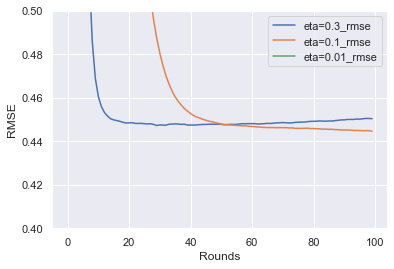

In [103]:
for col in df_score.columns:
    sns.lineplot(data=df_score, x=df_score.index, y=col, label=col)

plt.ylabel('RMSE')
plt.xlabel('Rounds')
plt.ylim(0.4, 0.5)

Ans: 0.1